In [1]:
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
from utils import *
from preprocessing import Dataset

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [3]:
with gzip.open('data.pickle.gz', 'rb') as fh:
    data = pickle.load(fh, )

In [4]:
dataset = Dataset(data)

In [5]:
dataset[0]

energy_per_atom                                                  -7.284505
initial_structure        [[1.27612629e-07 1.84192955e+00 3.71975100e+00...
defect_representation          [[-7.98855051 17.50569919  5.28204642] X0+]
subgroup                                                                X1
group                                                                   X1
Name: 0, dtype: object

In [10]:
df_x5_diff = dataset.get_subgroup_df('X5_diff')

In [11]:
y = df_x5_diff.energy_per_atom

In [12]:
x = []
for defect_repr in df_x5_diff.defect_representation:
    x.append(defect_repr[0].distance(defect_repr[1]))

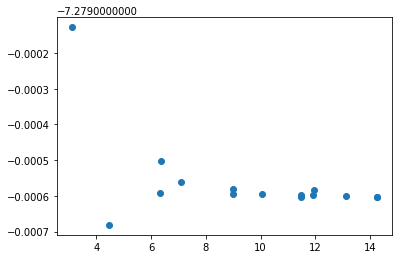

In [13]:
plt.scatter(x, y)

In [6]:
def get_nn(structure, site, atol=1e-1):
    """
    returns indicies of neighbouring sites in structure for given site.
    """
    layer_coords = build_layers_coords(structure)
    layer = get_layer(site, layer_coords)
    nearest_neighbor_ids = []
    dx, dy = get_x_y_dist(structure)
    for i,s in enumerate(structure):
        if max(np.isclose(site.distance(s), [dx, dy], atol=atol)) == 1 and get_layer(s, layer_coords) == layer:
            nearest_neighbor_ids.append(i)    
    return nearest_neighbor_ids

In [7]:
def swap_sites(structure, defect_site, idx):
    """
    Swap defect site with site in structure by index.
    Works correctly when defect is substitution or vacancy
    """
    defect_species = defect_site.species_string
    site_species = structure[idx].species_string
    if defect_species == site_species:
        return structure.copy(), defect_site
    new_defect_site = PeriodicSite(defect_site.species, 
                                   structure[idx].frac_coords, 
                                   structure[idx].lattice)
    if defect_species != "X0+":
        defect_idx = find_site(structure, defect_site)
        indices_species_map = {idx: defect_species, defect_idx: site_species}
        transformation = ReplaceSiteSpeciesTransformation(indices_species_map)
        return transformation.apply_transformation(structure), new_defect_site
    insert_transf = InsertSitesTransformation([site_species],
                                              [defect_site.frac_coords])
    remove_transf = RemoveSitesTransformation([idx])
    removed_s = remove_transf.apply_transformation(structure)
    return insert_transf.apply_transformation(removed_s), new_defect_site

In [8]:
def generate_neighbouring_structures(structure, defects, checker):
    """
    Only one swap.
    """
    result_structures = []
    defect_reprs = []
    for i, defect_site in enumerate(defects):
        nns = get_nn(structure, defect_site)
        for n_idx in nns:
            new_structure, new_defect_site = swap_sites(structure, 
                                                        defect_site, 
                                                        n_idx)
            new_defect_repr = defects.copy()
            new_defect_repr[i] = new_defect_site
            
            # check if swapped with another defect
            found, idx = safe_find_site(defects, new_defect_site)
            if found:
                swapped_defect_site = PeriodicSite(defects[idx].species, 
                                   defect_site.frac_coords, 
                                   defect_site.lattice)
                new_defect_repr[idx] = swapped_defect_site
            # check if got something new
            is_new = True
            for reprn in defect_reprs:
                if checker.are_symmetrically_equivalent(reprn, 
                                                        new_defect_repr, 
                                                        symm_prec=0.01):
                    is_new = False
                    break
            if is_new or len(defect_reprs) == 0:
                result_structures.append(new_structure)
                defect_reprs.append(new_defect_repr)
    return result_structures, defect_reprs

In [9]:
def get_energy_idx(defect_representation, group_df, checker):
    for i, row in group_df.iterrows():
        if checker.are_symmetrically_equivalent(defect_representation,
                                                row.defect_representation,
                                                symm_prec=0.01):
            return row.energy_per_atom, row.idx
    raise ValueError(f"Not found symmetrically equivalent structure for {defect_representation}")

In [10]:
finder = SpacegroupAnalyzer(dataset.get_full_structure(), symprec=1e-1)
checker = finder.get_space_group_operations()

In [11]:
def generate_group_adj_dict(group_df, checker, thr=0.0):
    """
    Parallel
    """
    def get_item(i, row):
        adj_dict = {}
        cur_energy = row.energy_per_atom
        ns, defect_reprs = generate_neighbouring_structures(
            row.initial_structure, row.defect_representation, checker
        )
        adj_dict[row.idx] = []
        for defect_repr in defect_reprs:
            energy, idx = get_energy_idx(defect_repr, group_df, checker)
            if energy - cur_energy <= thr:
                adj_dict[row.idx].append(idx)
        return adj_dict
            
    result = Parallel(n_jobs=-3, verbose=100)(
        delayed(get_item)(i, row) for i, row in group_df.iterrows()
    )
    adj_dict = {}
    for entry in result:
        adj_dict |= entry
    return adj_dict

In [12]:
def check_reachable(adj_dict, min_idx):
    is_reachable = True
    digraph = nx.from_dict_of_lists(adj_dict, create_using=nx.DiGraph)
    for node in digraph:
        if not nx.has_path(digraph, node, min_idx):
            print(f"No path from {node} to {min_idx}!")
            is_reachable = False
    return is_reachable

In [13]:
def check_all_groups(groups, data, checker):
    all_adjs = {}
    all_reachability = {}
    for group in tqdm(groups):
        group_df = data[data.group == group]
        all_adjs[group] = generate_group_adj_dict(group_df, checker)
        min_idx = group_df.iloc[group_df.energy_per_atom.argmin()].idx
        all_reachability[group] = check_reachable(all_adjs[group], 
                                                     min_idx)
    return all_adjs, all_reachability

In [14]:
from pymatgen.core.structure import Molecule, Element
from pymatgen.io.babel import BabelMolAdaptor

In [68]:
from openbabel import openbabel, pybel

In [15]:
dataset[24].defect_representation

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999994 22.10315553833868 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
PeriodicSite: X0+ (3.2031, 7.3604, 3.7198) [0.2920, 0.3330, 0.2500]
PeriodicSite: Se (23.9274, 0.9210, 2.1549) [0.9583, 0.0417, 0.1448]
PeriodicSite: Se (1.5952, 0.9210, 5.2846) [0.0833, 0.0417, 0.3552]

In [64]:
def create_obmol(defect_representation):
    mol = openbabel.OBMol()
    n = len(defect_representation)
    for defect in defect_representation:
        a = mol.NewAtom()
        coords = defect.coords
        atomic_num = defect.specie.Z
        if defect.specie.symbol == 'X':
            atomic_num = 0
        a.SetAtomicNum(atomic_num)
        a.SetVector(*coords)
    for i in range(n):
        for j in range(i+1, n, 1):
            mol.AddBond(i+1, j+1, 1)
    return mol
        

In [66]:
obmol = create_obmol(d24)

In [69]:
pbmol = pybel.Molecule(obmol)

In [73]:
pbmol.draw()

In [74]:
pbmol.write("sdf", "outputfile.sdf")

In [16]:
d24 = dataset[24].defect_representation

In [33]:
pmg_mol = Molecule([site.species for site in d24], [[int(c*100) for c in site.coords] for site in d24 ])
pmg_mol

Molecule Summary
Site: X0+ (320.0000, 736.0000, 371.0000)
Site: Se (2392.0000, 92.0000, 215.0000)
Site: Se (159.0000, 92.0000, 528.0000)

In [38]:
pmg_mol[1].specie.Z

34

In [82]:
pybel.Fingerprint

openbabel.pybel.Fingerprint

In [83]:
spectromaker = pybel.ob.OBSpectrophore()

In [84]:
myspec = spectromaker.GetSpectrophore(pbmol.OBMol)

In [86]:
rdmol = Chem.SDMolSupplier('outputfile.sdf')

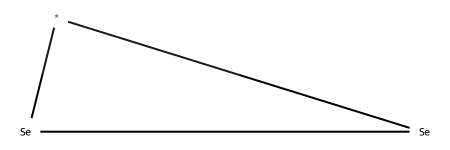

In [90]:
rdmol[0]

In [77]:
from rdkit import Chem

In [78]:
from e3fp.fingerprint.generate import fp, fprints_dict_from_mol

In [91]:
fprints_dict_from_mol(rdmol[0])

2022-05-22 23:26:17,047|INFO|Generating fingerprints for .
2022-05-22 23:26:17,055|ERROR|Error generating fingerprints for .
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/e3fp/fingerprint/generate.py", line 197, in fprints_dict_from_mol
    fprint.name = MolItemName.from_str(name).to_conf_name(j)
  File "/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/e3fp/conformer/util.py", line 65, in from_str
    fields = cls.mol_item_name_to_dict(
  File "/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/e3fp/conformer/util.py", line 136, in mol_item_name_to_dict
    groups = match.groups()
AttributeError: 'NoneType' object has no attribute 'groups'


{}

In [54]:
import pybel

In [34]:
BabelMolAdaptor(pmg_mol).openbabel_mol


OverflowError: in method 'OBAtom_SetAtomicNum', argument 2 of type 'int'

In [21]:
mol = Molecule(BabelMolAdaptor(pmg_mol).openbabel_mol)

OverflowError: in method 'OBAtom_SetAtomicNum', argument 2 of type 'int'

In [26]:
pybel.__dict__

{'__name__': 'pybel',
 '__doc__': 'Parsing, validation, compilation, and data exchange of Biological Expression Language (BEL).',
 '__package__': 'pybel',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7f97ef49b640>,
 '__spec__': ModuleSpec(name='pybel', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f97ef49b640>, origin='/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pybel/__init__.py', submodule_search_locations=['/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pybel']),
 '__path__': ['/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pybel'],
 '__file__': '/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pybel/__init__.py',
 '__cached__': '/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pybel/__pycache__/__init__.cpython-39.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents 

In [26]:
ad = generate_group_adj_dict(dataset.get_subgroup_df('X2_diff'), checker)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/

[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done   2 out of  10 | elapsed:    3.5s remaining:   13.8s
[Parallel(n_jobs=-3)]: Done   3 out of  10 | elapsed:    3.6s remaining:    8.3s
[Parallel(n_jobs=-3)]: Done   4 out of  10 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-3)]: Done   5 out of  10 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-3)]: Done   6 out of  10 | elapsed:    5.5s remaining:    3.7s
[Parallel(n_jobs=-3)]: Done   7 out of  10 | elapsed:    5.7s remaining:    2.5s
[Parallel(n_jobs=-3)]: Done   8 out of  10 | elapsed:    6.0s remaining:    1.5s
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:    6.7s finished


In [23]:
ad

{1: [],
 4: [4, 292, 208, 453],
 208: [208, 1, 582],
 292: [208],
 370: [1, 582, 597, 370],
 398: [4, 292, 398],
 453: [208, 582],
 500: [4, 453],
 582: [1],
 597: []}

In [24]:
check_reachable(ad, dataset.subgroup_energy_argmin_idx('X2_diff'))

No path from 1 to 597!
No path from 4 to 597!
No path from 208 to 597!
No path from 292 to 597!
No path from 398 to 597!
No path from 453 to 597!
No path from 500 to 597!
No path from 582 to 597!


False

In [ ]:
dataset.data[dataset.data.idx == 597]

In [ ]:
ad = generate_group_adj_dict(dataset.get_group_df('X2'), checker)
check_reachable(ad, dataset.group_energy_argmin_idx('X2'))

In [ ]:
dataset.get_subgroup_df('X2_diff')

In [ ]:
assert False

In [ ]:
group = 'X5'
group_df = data[data.group == group]
adj_dict = generate_group_adj_dict(group_df, checker)
min_idx = group_df.iloc[group_df.energy_per_atom.argmin()].idx
check_reachable(adj_dict, min_idx)

In [ ]:
%time
all_adjs, all_reachability = check_all_groups(data.group.unique(), data, 
                                                 checker)

In [18]:
!pip install pybel

     |████████████████████████████████| 387 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 464 kB/s eta 0:00:01
     |████████████████████████████████| 101 kB 3.7 MB/s ta 0:00:01
     |████████████████████████████████| 96 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 153 kB 6.8 MB/s eta 0:00:01
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5908 sha256=d362d5bf13523d8d4fa5f248f0699a19037f9f1bf4da63a88d4cc58df1cbbcdd
  Stored in directory: /home/user/.cache/pip/wheels/14/1e/97/126009a0884bdf7e26436cace73d9a4f4596dada4fdc4950ce
Successfully built ratelimit


In [75]:
!conda install -c conda-forge rdkit

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base conda


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/user/anaconda3/envs/bacc

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.3             |       h516909a_0         560 KB  conda-forge
    boost-1.74.0               |   py39h5472131_3         368 KB  conda-forge
    boost-cpp-1.74.0           |       h312852a_4        16.3 MB  conda-forge
    bzip2-1.0.8            

Proceed ([y]/n)? ^C

CondaSystemExit: 
Operation aborted.  Exiting.



In [76]:
1

1